In [36]:
from jmetal.algorithm.multiobjective import RandomSearch, NSGAII, SPEA2, MOEAD
from jmetal.operator.crossover import SBXCrossover, DifferentialEvolutionCrossover
from jmetal.operator.mutation import PolynomialMutation
from jmetal.problem import Kursawe
from jmetal.problem.multiobjective.constrained import Binh2
from jmetal.problem.multiobjective.dtlz import DTLZ2, DTLZ7
from jmetal.util.aggregation_function import PenaltyBoundaryIntersection
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.solution import get_non_dominated_solutions, print_function_values_to_file
from jmetal.core.quality_indicator import HyperVolume, NormalizedHyperVolume, InvertedGenerationalDistance
import numpy as np
import matplotlib.pyplot as plt

def execute_analysis(problem, algorithm_max_evaluations, algorithm_per_problem_iterations):
    problem_name = problem.name() 
    ref_front = np.loadtxt(f"resources/reference_fronts/{problem_name}.pf")
    pop_size = 100
    off_size = 100
    cro = 0.7
    mut = 0.5
    
    rnd = RandomSearch(
        problem=problem,
        termination_criterion=StoppingByEvaluations(max_evaluations=algorithm_max_evaluations)
    )
    
    nsgaII = NSGAII(
            problem=problem,
            population_size=pop_size,
            offspring_population_size=off_size,
            mutation=PolynomialMutation(mut, distribution_index=20),
            crossover=SBXCrossover(probability=cro, distribution_index=20),
            termination_criterion=StoppingByEvaluations(max_evaluations=algorithm_max_evaluations))

    spea2 = SPEA2(
            problem=problem,
            population_size=pop_size,
            offspring_population_size=off_size,
            mutation=PolynomialMutation(mut, distribution_index=20),
            crossover=SBXCrossover(probability=cro, distribution_index=20),
            termination_criterion=StoppingByEvaluations(max_evaluations=algorithm_max_evaluations))
    
    moead = MOEAD(
            problem=problem,
            population_size=pop_size,
            crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5),
            mutation=PolynomialMutation(mut, distribution_index=20),
            aggregation_function=PenaltyBoundaryIntersection(dimension=problem.number_of_objectives()),
            neighbor_size=20,
            neighbourhood_selection_probability=0.9,
            max_number_of_replaced_solutions=2,
            weight_files_path="resources/MOEAD_weights",
            termination_criterion=StoppingByEvaluations(max_evaluations=algorithm_max_evaluations))
    
    algorithms = [rnd, nsgaII, spea2, moead]

    for algorithm in algorithms:
        for i in range(algorithm_per_problem_iterations):
            algorithm.run()
            front = get_non_dominated_solutions(algorithm.result())
            filepath = f'results/comparative_analysis/FUN.{algorithm.get_name()}.{problem_name}.{i}'
            print_function_values_to_file(front, filepath)

            aprx_front = np.loadtxt(filepath)

            hv_ref_point = np.max(ref_front, axis=0) + 0.1
            nhv = NormalizedHyperVolume(hv_ref_point, ref_front)
            hv = HyperVolume(hv_ref_point)
            igd = InvertedGenerationalDistance(ref_front)
            print(f'{algorithm.get_name()}, {problem_name}, iteration = {i}, HV = {hv.compute(aprx_front.reshape(-1, problem.number_of_objectives()))}, nHV = {nhv.compute(aprx_front.reshape(-1, problem.number_of_objectives()))}, IGD = {igd.compute(aprx_front.reshape(-1, problem.number_of_objectives()))}')
            


In [37]:
def generate_plots_2d(problem_name, iteration):
    ref_front = np.loadtxt(f"resources/reference_fronts/{problem_name}.pf")
    ref_x = ref_front[:, 0]
    ref_y = ref_front[:, 1]

    hv_ref_point = np.max(ref_front, axis=0) + 0.1
    hv = HyperVolume(hv_ref_point)
    nhv = NormalizedHyperVolume(hv_ref_point, ref_front)
    igd = InvertedGenerationalDistance(ref_front)

    fun1 = np.loadtxt(f"results/comparative_analysis/FUN.Random Search.{problem_name}.{iteration}").reshape(-1, 2)
    fun1_x = fun1[:, 0]
    fun1_y = fun1[:, 1]
    fun1_hv = hv.compute(fun1)
    fun1_nhv = nhv.compute(fun1)
    fun1_igd = igd.compute(fun1)

    fun2 = np.loadtxt(f"results/comparative_analysis/FUN.NSGAII.{problem_name}.{iteration}").reshape(-1, 2)
    fun2_x = fun2[:, 0]
    fun2_y = fun2[:, 1]
    fun2_hv = hv.compute(fun2)
    fun2_nhv = nhv.compute(fun2)
    fun2_igd = igd.compute(fun2)

    fun3 = np.loadtxt(f"results/comparative_analysis/FUN.SPEA2.{problem_name}.{iteration}").reshape(-1, 2)
    fun3_x = fun3[:, 0]
    fun3_y = fun3[:, 1]
    fun3_hv = hv.compute(fun3)
    fun3_nhv = nhv.compute(fun3)
    fun3_igd = igd.compute(fun3)

    fun4 = np.loadtxt(f"results/comparative_analysis/FUN.MOEAD.{problem_name}.{iteration}").reshape(-1, 2)
    fun4_x = fun4[:, 0]
    fun4_y = fun4[:, 1]
    fun4_hv = hv.compute(fun4)
    fun4_nhv = nhv.compute(fun4)
    fun4_igd = igd.compute(fun4)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), constrained_layout=True)
    bbox_props = dict(boxstyle='square', facecolor='w', alpha=1)
    ref_s = 2
    fun_s = 20
    ndigits = 4
    legend_h = -30
    legend_v = -30
    alpha = 0.7
    fontsize = 12

    plt.subplot(221) # (rows-columns-index)
    plt.xlabel("$f_1{(x)}$")
    plt.ylabel("$f_2{(x)}$")
    plt.grid(True)
    plt.scatter(ref_x, ref_y, marker="o", facecolors='blue', s=ref_s)
    plt.scatter(fun1_x, fun1_y, marker="o", facecolors='red', s=fun_s, alpha=alpha)
    plt.title(f'a) Random Search (nHV = {round(fun1_nhv, ndigits)}, IGD = {round(fun1_igd, ndigits)})', fontsize=fontsize)

    plt.subplot(222)
    plt.xlabel("$f_1{(x)}$")
    plt.ylabel("$f_2{(x)}$")
    plt.grid(True)
    plt.scatter(ref_x, ref_y, marker="o", facecolors='blue', s=ref_s)
    plt.scatter(fun2_x, fun2_y, marker="o", facecolors='red', s=fun_s, alpha=alpha)
    plt.title(f'b) NSGAII (nHV = {round(fun2_nhv, ndigits)}, IGD = {round(fun2_igd, ndigits)})', fontsize=fontsize)

    plt.subplot(223)
    plt.xlabel("$f_1{(x)}$")
    plt.ylabel("$f_2{(x)}$")
    plt.grid(True)
    plt.scatter(ref_x, ref_y, marker="o", facecolors='blue', s=ref_s)
    plt.scatter(fun3_x, fun3_y, marker="o", facecolors='red', s=fun_s, alpha=alpha)
    plt.title(f'c) SPEA2 (nHV = {round(fun3_nhv, ndigits)}, IGD = {round(fun3_igd, ndigits)})', fontsize=fontsize)

    plt.subplot(224)
    plt.xlabel("$f_1{(x)}$")
    plt.ylabel("$f_2{(x)}$")
    plt.grid(True)
    plt.scatter(ref_x, ref_y, marker="o", facecolors='blue', s=ref_s)
    plt.scatter(fun4_x, fun4_y, marker="o", facecolors='red', s=fun_s, alpha=alpha)
    plt.title(f'd) MOEAD (nHV = {round(fun4_nhv, ndigits)}, IGD = {round(fun4_igd, ndigits)})', fontsize=fontsize)

    plt.show()

In [38]:
def generate_plots_3d(problem_name, iteration):
    ref_front = np.loadtxt(f"resources/reference_fronts/{problem_name}.pf")
    ref_x = ref_front[:, 0]
    ref_y = ref_front[:, 1]
    ref_z = ref_front[:, 2]
    
    hv_ref_point = np.max(ref_front, axis=0) + 0.1
    hv = HyperVolume(hv_ref_point)
    nhv = NormalizedHyperVolume(hv_ref_point, ref_front)
    igd = InvertedGenerationalDistance(ref_front)

    fun1 = np.loadtxt(f"results/comparative_analysis/FUN.Random Search.{problem_name}.{iteration}").reshape(-1, 3)
    fun1_x = fun1[:, 0]
    fun1_y = fun1[:, 1]
    fun1_z = fun1[:, 2]
    fun1_hv = hv.compute(fun1)
    fun1_nhv = nhv.compute(fun1)
    fun1_igd = igd.compute(fun1)

    fun2 = np.loadtxt(f"results/comparative_analysis/FUN.NSGAII.{problem_name}.{iteration}").reshape(-1, 3)
    fun2_x = fun2[:, 0]
    fun2_y = fun2[:, 1]
    fun2_z = fun2[:, 2]
    fun2_hv = hv.compute(fun2)
    fun2_nhv = nhv.compute(fun2)
    fun2_igd = igd.compute(fun2)
 
    fun3 = np.loadtxt(f"results/comparative_analysis/FUN.SPEA2.{problem_name}.{iteration}").reshape(-1, 3)
    fun3_x = fun3[:, 0]
    fun3_y = fun3[:, 1]
    fun3_z = fun3[:, 2]
    fun3_hv = hv.compute(fun3)
    fun3_nhv = nhv.compute(fun3)
    fun3_igd = igd.compute(fun3)
 
    fun4 = np.loadtxt(f"results/comparative_analysis/FUN.MOEAD.{problem_name}.{iteration}").reshape(-1, 3)
    fun4_x = fun4[:, 0]
    fun4_y = fun4[:, 1]
    fun4_z = fun4[:, 2]
    fun4_hv = hv.compute(fun4)
    fun4_nhv = nhv.compute(fun4)
    fun4_igd = igd.compute(fun4)
    
    fig = plt.figure(figsize=(12, 10))
    elev = 30
    azim = 45
    roll = 0
    ndigits = 4
    fontsize = 12
    zoom = 0.9
    ax = fig.add_subplot(221, projection='3d')
    ax.scatter3D(ref_x, ref_y, ref_z)
    ax.scatter3D(fun1_x, fun1_y, fun1_z)
    ax.set_box_aspect(None, zoom=zoom)
    ax.set_xlabel('$f_1{(x)}$')
    ax.set_ylabel('$f_2{(x)}$')
    ax.set_zlabel('$f_3{(x)}$')
    ax.view_init(elev, azim, roll)
    ax.set_title(f'a) Random Search (nHV = {round(fun1_nhv, ndigits)}, IGD = {round(fun1_igd, ndigits)})', fontsize=fontsize)
    
    ax = fig.add_subplot(222, projection='3d')
    ax.scatter3D(ref_x, ref_y, ref_z)
    ax.scatter3D(fun2_x, fun2_y, fun2_z)
    ax.set_box_aspect(None, zoom=zoom)
    ax.set_xlabel('$f_1{(x)}$')
    ax.set_ylabel('$f_2{(x)}$')
    ax.set_zlabel('$f_3{(x)}$')
    ax.view_init(elev, azim, roll)
    ax.set_title(f'b) NSGAII (nHV = {round(fun2_nhv, ndigits)}, IGD = {round(fun2_igd, ndigits)})', fontsize=fontsize)

    ax = fig.add_subplot(223, projection='3d')
    ax.scatter3D(ref_x, ref_y, ref_z)
    ax.scatter3D(fun3_x, fun3_y, fun3_z)
    ax.set_box_aspect(None, zoom=zoom)
    ax.set_xlabel('$f_1{(x)}$')
    ax.set_ylabel('$f_2{(x)}$')
    ax.set_zlabel('$f_3{(x)}$')
    ax.view_init(elev, azim, roll)
    ax.set_title(f'c) SPEA2 (nHV = {round(fun3_nhv, ndigits)}, IGD = {round(fun3_igd, ndigits)})', fontsize=fontsize)

    ax = fig.add_subplot(224, projection='3d')
    ax.scatter3D(ref_x, ref_y, ref_z)
    ax.scatter3D(fun4_x, fun4_y, fun4_z)
    ax.set_box_aspect(None, zoom=zoom)
    ax.set_xlabel('$f_1{(x)}$')
    ax.set_ylabel('$f_2{(x)}$')
    ax.set_zlabel('$f_3{(x)}$')
    ax.view_init(elev, azim, roll)
    ax.set_title(f'd) MOEAD (nHV = {round(fun4_nhv, ndigits)}, IGD = {round(fun4_igd, ndigits)})', fontsize=fontsize)

    plt.show()

In [39]:
algorithm_max_evaluations = 10000
algorithm_per_problem_iterations = 10

In [40]:
problem = Kursawe()

In [41]:
execute_analysis(problem, algorithm_max_evaluations, algorithm_per_problem_iterations)

[2025-10-29 16:15:22,004] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:22,006] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:22,008] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:22,011] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-10-29 16:15:22,335] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:22,337] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Kursawe.0
[2025-10-29 16:15:22,361] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:22,362] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:22,363] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:22,365] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-10-29 16:15:22,567] [jmetal.core.algorithm

Random Search, Kursawe, iteration = 0, HV = 20.71528793539548, nHV = 0.25513348945015224, IGD = 0.7777227081720889


[2025-10-29 16:15:22,569] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Kursawe.1
[2025-10-29 16:15:22,611] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:22,612] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:22,615] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:22,619] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Kursawe, iteration = 1, HV = 21.57318915874231, nHV = 0.22428564931277606, IGD = 0.6986318062987402


[2025-10-29 16:15:22,949] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:22,953] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Kursawe.2
[2025-10-29 16:15:22,978] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:22,979] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:22,985] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:22,994] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Kursawe, iteration = 2, HV = 21.991894866319754, nHV = 0.20923010867423064, IGD = 0.5581635706813769


[2025-10-29 16:15:23,272] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:23,275] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Kursawe.3
[2025-10-29 16:15:23,320] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:23,334] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:23,344] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:23,346] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Kursawe, iteration = 3, HV = 22.852512403547525, nHV = 0.1782845971335717, IGD = 0.4154574807437119


[2025-10-29 16:15:23,660] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:23,671] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Kursawe.4
[2025-10-29 16:15:23,697] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:23,698] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:23,700] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:23,706] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Kursawe, iteration = 4, HV = 23.07801925843251, nHV = 0.1701759720144277, IGD = 0.3868206563258786


[2025-10-29 16:15:24,055] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:24,062] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Kursawe.5
[2025-10-29 16:15:24,093] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:24,095] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:24,097] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:24,106] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Kursawe, iteration = 5, HV = 23.346142455602166, nHV = 0.16053497687614704, IGD = 0.3565993469896856


[2025-10-29 16:15:24,528] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:24,531] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Kursawe.6
[2025-10-29 16:15:24,561] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:24,563] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:24,564] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:24,568] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Kursawe, iteration = 6, HV = 23.425147810731623, nHV = 0.15769415499746697, IGD = 0.3555984184626755


[2025-10-29 16:15:24,953] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:24,956] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Kursawe.7
[2025-10-29 16:15:24,998] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:24,999] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:25,007] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:25,015] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Kursawe, iteration = 7, HV = 23.625649786402374, nHV = 0.15048463865176176, IGD = 0.33239803714075383


[2025-10-29 16:15:25,422] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:25,429] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Kursawe.8
[2025-10-29 16:15:25,457] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:25,459] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:25,461] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:25,464] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Kursawe, iteration = 8, HV = 23.77451091145155, nHV = 0.1451319895783958, IGD = 0.31692001659780494


[2025-10-29 16:15:25,850] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:25,852] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Kursawe.9
[2025-10-29 16:15:25,877] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:25,880] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:25,884] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:25,887] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Kursawe, iteration = 9, HV = 23.930401897526284, nHV = 0.13952656544981024, IGD = 0.3035077156740384


[2025-10-29 16:15:29,951] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:29,964] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Kursawe.0
[2025-10-29 16:15:29,995] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:29,998] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:30,003] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:30,006] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Kursawe, iteration = 0, HV = 27.445550445439025, nHV = 0.01313119787809991, IGD = 0.04056914965918381


[2025-10-29 16:15:34,565] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:34,577] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Kursawe.1
[2025-10-29 16:15:34,599] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:34,601] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:34,608] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:34,611] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Kursawe, iteration = 1, HV = 27.440126175772743, nHV = 0.013326240149836965, IGD = 0.04473285145138771


[2025-10-29 16:15:38,449] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:38,459] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Kursawe.2
[2025-10-29 16:15:38,477] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:38,479] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:38,482] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:38,486] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Kursawe, iteration = 2, HV = 27.4795850666611, nHV = 0.011907403662608673, IGD = 0.04500144726572008


[2025-10-29 16:15:41,718] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:41,726] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Kursawe.3
[2025-10-29 16:15:41,747] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:41,752] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:41,757] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:41,758] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Kursawe, iteration = 3, HV = 27.46821539411007, nHV = 0.012316226766858618, IGD = 0.041776173751092105


[2025-10-29 16:15:45,022] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:45,031] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Kursawe.4
[2025-10-29 16:15:45,048] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:45,050] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:45,051] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:45,054] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Kursawe, iteration = 4, HV = 27.423731196263514, nHV = 0.013915759890796409, IGD = 0.0429867852956823


[2025-10-29 16:15:49,058] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:49,068] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Kursawe.5
[2025-10-29 16:15:49,088] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:49,090] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:49,093] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:49,096] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Kursawe, iteration = 5, HV = 27.464984489153306, nHV = 0.01243240149291458, IGD = 0.04219370738284097


[2025-10-29 16:15:52,237] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:52,245] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Kursawe.6
[2025-10-29 16:15:52,271] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:52,273] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:52,284] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:52,286] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Kursawe, iteration = 6, HV = 27.408409931233628, nHV = 0.01446667172246452, IGD = 0.04498344965136296


[2025-10-29 16:15:55,950] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:55,961] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Kursawe.7
[2025-10-29 16:15:55,982] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:55,984] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:55,991] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:55,995] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Kursawe, iteration = 7, HV = 27.50277631451675, nHV = 0.011073508236225549, IGD = 0.04285291516911392


[2025-10-29 16:15:59,017] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:15:59,021] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Kursawe.8
[2025-10-29 16:15:59,041] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:15:59,044] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:15:59,048] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:15:59,051] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Kursawe, iteration = 8, HV = 27.41993864159596, nHV = 0.01405213004264283, IGD = 0.043028449124363245


[2025-10-29 16:16:02,079] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:16:02,086] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Kursawe.9
[2025-10-29 16:16:02,104] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:16:02,106] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:16:02,109] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:16:02,116] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Kursawe, iteration = 9, HV = 27.40959924990648, nHV = 0.014423906994668112, IGD = 0.04195735604827989


[2025-10-29 16:21:07,952] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:21:07,964] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Kursawe.0
[2025-10-29 16:21:07,990] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:21:07,993] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:21:07,997] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:21:07,999] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Kursawe, iteration = 0, HV = 27.4384539616262, nHV = 0.01338636851107966, IGD = 0.03636767377850187


[2025-10-29 16:27:19,717] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:27:19,728] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Kursawe.1
[2025-10-29 16:27:19,754] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:27:19,756] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:27:19,759] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:27:19,779] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Kursawe, iteration = 1, HV = 27.461194131671974, nHV = 0.012568692639803758, IGD = 0.03452152889896598


[2025-10-29 16:32:13,163] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:32:13,175] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Kursawe.2
[2025-10-29 16:32:13,198] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:32:13,200] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:32:13,204] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:32:13,206] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Kursawe, iteration = 2, HV = 27.487762963560343, nHV = 0.011613348298957882, IGD = 0.036250897491392764


[2025-10-29 16:35:55,614] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:35:55,619] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Kursawe.3
[2025-10-29 16:35:55,635] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:35:55,637] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:35:55,638] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:35:55,641] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Kursawe, iteration = 3, HV = 27.459806890525808, nHV = 0.012618574131920024, IGD = 0.035695090536924004


[2025-10-29 16:38:32,083] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:38:32,093] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Kursawe.4
[2025-10-29 16:38:32,110] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:38:32,113] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:38:32,116] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:38:32,119] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Kursawe, iteration = 4, HV = 27.321578107159322, nHV = 0.017588912552744862, IGD = 0.037860287664149436


[2025-10-29 16:40:55,049] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:40:55,057] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Kursawe.5
[2025-10-29 16:40:55,072] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:40:55,074] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:40:55,076] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:40:55,079] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Kursawe, iteration = 5, HV = 27.456770590836243, nHV = 0.012727751371541474, IGD = 0.034382142269576914


[2025-10-29 16:44:14,231] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:44:14,243] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Kursawe.6
[2025-10-29 16:44:14,262] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:44:14,264] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:44:14,268] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:44:14,280] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Kursawe, iteration = 6, HV = 27.463742205251304, nHV = 0.0124770707091032, IGD = 0.03388767877494399


[2025-10-29 16:47:38,734] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:47:38,822] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Kursawe.7
[2025-10-29 16:47:38,899] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:47:38,902] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:47:38,909] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:47:38,918] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Kursawe, iteration = 7, HV = 27.514455403177887, nHV = 0.010653559353808295, IGD = 0.033964604041069685


[2025-10-29 16:51:43,661] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:51:43,670] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Kursawe.8
[2025-10-29 16:51:43,688] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:51:43,690] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:51:43,692] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:51:43,696] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Kursawe, iteration = 8, HV = 27.52631972438665, nHV = 0.010226950002957147, IGD = 0.032985879823443566


[2025-10-29 16:55:53,537] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:55:53,550] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Kursawe.9
[2025-10-29 16:55:53,566] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:55:53,568] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:55:53,573] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:55:53,576] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Kursawe, iteration = 9, HV = 27.405704568292478, nHV = 0.01456394935915628, IGD = 0.03632804686336559


[2025-10-29 16:55:57,477] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:55:57,481] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Kursawe.0
[2025-10-29 16:55:57,496] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:55:57,499] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:55:57,501] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:55:57,504] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Kursawe, iteration = 0, HV = 27.055556818162756, nHV = 0.027154328678497652, IGD = 0.06095342482876891


[2025-10-29 16:56:02,285] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:02,293] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Kursawe.1
[2025-10-29 16:56:02,306] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:02,308] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:02,311] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:02,314] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Kursawe, iteration = 1, HV = 27.069518526801186, nHV = 0.026652302868996336, IGD = 0.057094489905181844


[2025-10-29 16:56:06,154] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:06,161] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Kursawe.2
[2025-10-29 16:56:06,175] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:06,177] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:06,178] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:06,181] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Kursawe, iteration = 2, HV = 26.839856655149443, nHV = 0.03491033131045884, IGD = 0.05998246985005818


[2025-10-29 16:56:10,001] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:10,006] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Kursawe.3
[2025-10-29 16:56:10,023] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:10,025] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:10,026] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:10,029] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Kursawe, iteration = 3, HV = 27.189636148472296, nHV = 0.02233319352382379, IGD = 0.052132889338175975


[2025-10-29 16:56:13,715] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:13,721] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Kursawe.4
[2025-10-29 16:56:13,736] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:13,740] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:13,743] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:13,746] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Kursawe, iteration = 4, HV = 27.18894700555427, nHV = 0.022357973265347164, IGD = 0.05256787041105879


[2025-10-29 16:56:17,679] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:17,683] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Kursawe.5
[2025-10-29 16:56:17,699] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:17,701] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:17,702] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:17,704] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Kursawe, iteration = 5, HV = 26.988049055285924, nHV = 0.029581727801595292, IGD = 0.05714337818288139


[2025-10-29 16:56:21,864] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:21,868] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Kursawe.6
[2025-10-29 16:56:21,887] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:21,888] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:21,890] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:21,892] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Kursawe, iteration = 6, HV = 27.006982415084273, nHV = 0.028900934674801038, IGD = 0.05628716608463099


[2025-10-29 16:56:25,485] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:25,489] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Kursawe.7
[2025-10-29 16:56:25,505] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:25,507] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:25,510] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:25,513] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Kursawe, iteration = 7, HV = 26.893641108758164, nHV = 0.03297638579127027, IGD = 0.05706845412682686


[2025-10-29 16:56:29,099] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:29,103] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Kursawe.8
[2025-10-29 16:56:29,119] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:29,121] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:29,123] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:29,125] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Kursawe, iteration = 8, HV = 27.008194015285465, nHV = 0.02885736876266609, IGD = 0.05519751714154312


[2025-10-29 16:56:33,456] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:33,463] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Kursawe.9


MOEAD, Kursawe, iteration = 9, HV = 27.047125711566384, nHV = 0.027457488787596795, IGD = 0.056585844588285514


In [42]:
problem = Binh2()

In [43]:
execute_analysis(problem, algorithm_max_evaluations, algorithm_per_problem_iterations)

[2025-10-29 16:56:33,811] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:33,812] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:33,815] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:33,817] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-10-29 16:56:34,986] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:35,222] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Binh2.0
[2025-10-29 16:56:35,292] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:35,294] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:35,295] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:35,298] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Binh2, iteration = 0, HV = 2187.4721485321425, nHV = 0.0017191506418272606, IGD = 0.058319957694844854


[2025-10-29 16:56:36,507] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:37,107] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Binh2.1
[2025-10-29 16:56:37,202] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:37,203] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:37,204] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:37,208] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Binh2, iteration = 1, HV = 2189.06370055138, nHV = 0.0009928255534698005, IGD = 0.03631142717615232


[2025-10-29 16:56:39,203] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:40,302] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Binh2.2
[2025-10-29 16:56:40,547] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:40,548] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:40,550] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:40,554] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Binh2, iteration = 2, HV = 2189.69073366776, nHV = 0.0007066709834947504, IGD = 0.028185879272364846


[2025-10-29 16:56:42,170] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:43,775] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Binh2.3
[2025-10-29 16:56:43,901] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:43,902] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:43,903] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:43,906] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Binh2, iteration = 3, HV = 2190.0457350577612, nHV = 0.0005446615657421772, IGD = 0.023244019996765224


[2025-10-29 16:56:45,662] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:48,454] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Binh2.4
[2025-10-29 16:56:48,737] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:48,738] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:48,739] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:48,742] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Binh2, iteration = 4, HV = 2190.2939936796565, nHV = 0.0004313655733372279, IGD = 0.02011544685590741


[2025-10-29 16:56:51,628] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:56:54,743] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Binh2.5
[2025-10-29 16:56:54,933] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:56:54,934] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:56:54,935] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:56:54,938] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Binh2, iteration = 5, HV = 2190.4658980872487, nHV = 0.0003529148016852002, IGD = 0.01763321352637018


[2025-10-29 16:56:56,918] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:00,259] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Binh2.6
[2025-10-29 16:57:00,564] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:00,565] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:00,566] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:00,567] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Binh2, iteration = 6, HV = 2190.585308610823, nHV = 0.0002984202843602235, IGD = 0.01599794539841125


[2025-10-29 16:57:03,593] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:08,150] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Binh2.7
[2025-10-29 16:57:08,334] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:08,336] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:08,338] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:08,340] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Binh2, iteration = 7, HV = 2190.6905741030578, nHV = 0.0002503810327214584, IGD = 0.014514479492544892


[2025-10-29 16:57:10,671] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:15,777] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Binh2.8
[2025-10-29 16:57:16,157] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:16,159] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:16,160] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:16,164] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Binh2, iteration = 8, HV = 2190.774614866588, nHV = 0.0002120279570703154, IGD = 0.01335958986174698


[2025-10-29 16:57:18,853] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:24,772] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Binh2.9
[2025-10-29 16:57:24,966] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:24,968] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:24,971] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:24,974] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Binh2, iteration = 9, HV = 2190.8343332696277, nHV = 0.00018477470122935102, IGD = 0.012488177335172383


[2025-10-29 16:57:27,279] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:27,283] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Binh2.0
[2025-10-29 16:57:27,329] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:27,331] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:27,333] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:27,336] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Binh2, iteration = 0, HV = 2158.3027846193495, nHV = 0.015030962360957245, IGD = 0.47325149515650233


[2025-10-29 16:57:29,462] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:29,470] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Binh2.1
[2025-10-29 16:57:29,516] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:29,517] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:29,521] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:29,524] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Binh2, iteration = 1, HV = 2160.1031844237928, nHV = 0.014209326918800835, IGD = 0.4761938535424287


[2025-10-29 16:57:31,945] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:31,955] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Binh2.2
[2025-10-29 16:57:32,230] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:32,233] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:32,236] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:32,237] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Binh2, iteration = 2, HV = 2160.6400235405235, nHV = 0.01396433353235782, IGD = 0.4460525950475069


[2025-10-29 16:57:34,585] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:34,591] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Binh2.3
[2025-10-29 16:57:34,623] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:34,625] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:34,627] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:34,628] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Binh2, iteration = 3, HV = 2161.674513832272, nHV = 0.013492230677108918, IGD = 0.4359951846240405


[2025-10-29 16:57:36,808] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:36,813] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Binh2.4
[2025-10-29 16:57:36,850] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:36,852] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:36,853] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:36,855] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Binh2, iteration = 4, HV = 2162.6007942079596, nHV = 0.01306951079891272, IGD = 0.44450545627936894


[2025-10-29 16:57:39,156] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:39,160] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Binh2.5
[2025-10-29 16:57:39,195] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:39,198] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:39,201] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:39,202] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Binh2, iteration = 5, HV = 2163.886769718064, nHV = 0.012482639452759958, IGD = 0.44199927487198826


[2025-10-29 16:57:41,349] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:41,356] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Binh2.6
[2025-10-29 16:57:41,389] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:41,391] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:41,392] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:41,393] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Binh2, iteration = 6, HV = 2159.5131936346006, nHV = 0.01447857674972719, IGD = 0.46518819970919556


[2025-10-29 16:57:43,562] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:43,567] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Binh2.7
[2025-10-29 16:57:43,723] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:43,725] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:43,726] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:43,728] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Binh2, iteration = 7, HV = 2162.5735154083463, nHV = 0.013081959827470957, IGD = 0.4306166767237058


[2025-10-29 16:57:45,833] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:45,839] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Binh2.8
[2025-10-29 16:57:45,875] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:45,877] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:45,878] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:45,879] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Binh2, iteration = 8, HV = 2160.684781989222, nHV = 0.01394390744272167, IGD = 0.46580299044618834


[2025-10-29 16:57:48,596] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 16:57:48,603] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Binh2.9
[2025-10-29 16:57:48,639] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 16:57:48,640] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 16:57:48,641] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 16:57:48,644] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Binh2, iteration = 9, HV = 2162.2105593819183, nHV = 0.01324759944513898, IGD = 0.43785005333033244


[2025-10-29 17:16:02,081] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 17:16:02,088] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Binh2.0
[2025-10-29 17:16:02,123] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 17:16:02,126] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 17:16:02,128] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 17:16:02,129] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Binh2, iteration = 0, HV = 2163.838328277114, nHV = 0.012504746322942406, IGD = 0.4188951406441922


[2025-10-29 17:34:15,649] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 17:34:15,659] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Binh2.1
[2025-10-29 17:34:15,717] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 17:34:15,721] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 17:34:15,724] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 17:34:15,727] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Binh2, iteration = 1, HV = 2159.63644560359, nHV = 0.014422329139731183, IGD = 0.45837655281230816


[2025-10-29 17:52:27,873] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 17:52:27,882] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Binh2.2
[2025-10-29 17:52:27,918] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 17:52:27,920] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 17:52:27,922] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 17:52:27,923] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Binh2, iteration = 2, HV = 2163.6840283682236, nHV = 0.012575163056799621, IGD = 0.4135339184433089


[2025-10-29 18:11:04,108] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 18:11:04,112] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Binh2.3
[2025-10-29 18:11:04,147] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 18:11:04,148] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 18:11:04,150] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 18:11:04,153] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Binh2, iteration = 3, HV = 2165.710809252027, nHV = 0.011650215718154056, IGD = 0.3959895995857433


[2025-10-29 18:28:34,151] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 18:28:34,158] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Binh2.4
[2025-10-29 18:28:34,305] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 18:28:34,306] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 18:28:34,307] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 18:28:34,309] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Binh2, iteration = 4, HV = 2165.4793892379716, nHV = 0.01175582719683943, IGD = 0.40778225337660656


[2025-10-29 18:46:34,292] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 18:46:34,300] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Binh2.5
[2025-10-29 18:46:34,346] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 18:46:34,348] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 18:46:34,350] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 18:46:34,351] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Binh2, iteration = 5, HV = 2165.122260785995, nHV = 0.011918807326487535, IGD = 0.4052708591028611


[2025-10-29 19:04:05,646] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:04:05,654] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Binh2.6
[2025-10-29 19:04:05,798] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:04:05,799] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:04:05,800] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:04:05,801] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Binh2, iteration = 6, HV = 2161.113682591879, nHV = 0.013748173175568645, IGD = 0.46044608097012213


[2025-10-29 19:21:44,968] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:21:44,975] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Binh2.7
[2025-10-29 19:21:45,007] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:21:45,009] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:21:45,010] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:21:45,012] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Binh2, iteration = 7, HV = 2162.73471907869, nHV = 0.0130083924739125, IGD = 0.42622062201785604


[2025-10-29 19:39:03,061] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:39:03,066] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Binh2.8
[2025-10-29 19:39:03,100] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:39:03,103] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:39:03,106] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:39:03,108] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Binh2, iteration = 8, HV = 2163.82626092938, nHV = 0.012510253411182837, IGD = 0.4212263991011955


[2025-10-29 19:57:41,838] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:57:41,845] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Binh2.9
[2025-10-29 19:57:41,876] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:57:41,879] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:57:41,882] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:57:41,885] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Binh2, iteration = 9, HV = 2162.644015440891, nHV = 0.013049786237322225, IGD = 0.4441639501461938


[2025-10-29 19:57:45,448] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:57:45,454] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Binh2.0
[2025-10-29 19:57:45,485] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:57:45,486] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:57:45,487] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:57:45,490] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Binh2, iteration = 0, HV = 2176.582357299894, nHV = 0.0066888459350711305, IGD = 0.2603345016016534


[2025-10-29 19:57:49,115] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:57:49,119] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Binh2.1
[2025-10-29 19:57:49,151] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:57:49,153] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:57:49,170] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:57:49,174] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Binh2, iteration = 1, HV = 2176.7372774854607, nHV = 0.0066181461300317546, IGD = 0.25588158258450144


[2025-10-29 19:57:52,607] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:57:52,614] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Binh2.2
[2025-10-29 19:57:52,764] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:57:52,765] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:57:52,766] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:57:52,768] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Binh2, iteration = 2, HV = 2176.630877348005, nHV = 0.006666703191506751, IGD = 0.25471510212161147


[2025-10-29 19:57:56,564] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:57:56,571] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Binh2.3
[2025-10-29 19:57:56,600] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:57:56,606] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:57:56,608] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:57:56,611] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Binh2, iteration = 3, HV = 2176.8348443661394, nHV = 0.006573620238089051, IGD = 0.25582091014509484


[2025-10-29 19:58:01,043] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:58:01,052] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Binh2.4
[2025-10-29 19:58:01,107] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:58:01,109] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:58:01,112] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:58:01,113] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Binh2, iteration = 4, HV = 2176.7691003295204, nHV = 0.00660362336876219, IGD = 0.2548108837520331


[2025-10-29 19:58:05,497] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:58:05,501] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Binh2.5
[2025-10-29 19:58:05,538] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:58:05,540] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:58:05,541] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:58:05,543] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Binh2, iteration = 5, HV = 2176.8122561752734, nHV = 0.006583928647445614, IGD = 0.25596161380080007


[2025-10-29 19:58:09,013] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:58:09,019] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Binh2.6
[2025-10-29 19:58:09,174] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:58:09,175] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:58:09,176] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:58:09,179] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Binh2, iteration = 6, HV = 2176.660608678245, nHV = 0.006653134919277881, IGD = 0.25683249470368846


[2025-10-29 19:58:13,114] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:58:13,120] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Binh2.7
[2025-10-29 19:58:13,151] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:58:13,154] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:58:13,157] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:58:13,159] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Binh2, iteration = 7, HV = 2176.6633568702587, nHV = 0.006651880746757488, IGD = 0.2550878009368487


[2025-10-29 19:58:16,568] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:58:16,573] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Binh2.8
[2025-10-29 19:58:16,609] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-29 19:58:16,610] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-29 19:58:16,612] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-29 19:58:16,613] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, Binh2, iteration = 8, HV = 2176.9551140080553, nHV = 0.006518733651137865, IGD = 0.2538082784603882


[2025-10-29 19:58:20,518] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-29 19:58:20,523] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Binh2.9


MOEAD, Binh2, iteration = 9, HV = 2176.943324836043, nHV = 0.006524113790335351, IGD = 0.25287077155836


In [44]:
algorithm_max_evaluations = 100000

In [45]:
problem = DTLZ2()

In [47]:
execute_analysis(problem, algorithm_max_evaluations, algorithm_per_problem_iterations)

[2025-10-31 09:49:48,214] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 09:49:48,216] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 09:49:48,220] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 09:49:48,222] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-10-31 09:49:54,794] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 09:49:54,886] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ2.0
[2025-10-31 09:50:56,900] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 09:50:56,901] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 09:50:56,902] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 09:50:56,904] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ2, iteration = 0, HV = 0.3988304336532598, nHV = 0.4997536647288289, IGD = 0.17478250818615587


[2025-10-31 09:50:59,796] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 09:50:59,857] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ2.1
[2025-10-31 09:51:40,594] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 09:51:40,595] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 09:51:40,596] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 09:51:40,600] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ2, iteration = 1, HV = 0.44350205848529667, nHV = 0.443722793643742, IGD = 0.15716293334823994


[2025-10-31 09:51:43,749] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 09:51:43,824] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ2.2
[2025-10-31 09:52:30,395] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 09:52:30,397] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 09:52:30,399] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 09:52:30,401] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ2, iteration = 2, HV = 0.46617194618056507, nHV = 0.41528833307189306, IGD = 0.14627580549538016


[2025-10-31 09:52:33,031] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 09:52:33,105] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ2.3
[2025-10-31 09:53:27,715] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 09:53:27,719] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 09:53:27,721] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 09:53:27,723] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ2, iteration = 3, HV = 0.4757165981440943, nHV = 0.4033166359211552, IGD = 0.1432832264029622


[2025-10-31 09:53:33,895] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 09:53:34,079] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ2.4
[2025-10-31 09:54:31,456] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 09:54:31,457] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 09:54:31,458] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 09:54:31,459] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ2, iteration = 4, HV = 0.48544589135954674, nHV = 0.39111334633959804, IGD = 0.14034222891762013


[2025-10-31 09:54:34,093] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 09:54:34,227] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ2.5
[2025-10-31 09:55:18,424] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 09:55:18,425] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 09:55:18,426] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 09:55:18,431] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ2, iteration = 5, HV = 0.5017508829777568, nHV = 0.37066226834907545, IGD = 0.13337656185846616


[2025-10-31 09:55:22,419] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 09:55:22,635] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ2.6
[2025-10-31 09:56:16,243] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 09:56:16,244] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 09:56:16,246] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 09:56:16,251] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ2, iteration = 6, HV = 0.5138981315679613, nHV = 0.35542617782504926, IGD = 0.13043989666746778


[2025-10-31 09:56:18,991] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 09:56:19,109] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ2.7
[2025-10-31 09:57:03,220] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 09:57:03,222] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 09:57:03,224] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 09:57:03,226] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ2, iteration = 7, HV = 0.5163778248451953, nHV = 0.3523159400651813, IGD = 0.12989167936717114


[2025-10-31 09:57:06,337] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 09:57:06,435] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ2.8
[2025-10-31 09:57:59,643] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 09:57:59,644] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 09:57:59,646] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 09:57:59,650] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ2, iteration = 8, HV = 0.5274958627790134, nHV = 0.3383707712352777, IGD = 0.12471416632173432


[2025-10-31 09:58:02,266] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 09:58:02,378] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ2.9
[2025-10-31 09:58:52,565] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 09:58:52,568] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 09:58:52,573] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 09:58:52,576] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ2, iteration = 9, HV = 0.5344265449456819, nHV = 0.3296777326347696, IGD = 0.12059954075990456


[2025-10-31 09:59:26,176] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 09:59:26,181] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ2.0
[2025-10-31 10:00:12,910] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 10:00:12,914] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 10:00:12,917] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 10:00:12,920] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ2, iteration = 0, HV = 0.6605043403690014, nHV = 0.17154046476915696, IGD = 0.08342239272059375


[2025-10-31 10:00:41,374] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 10:00:41,383] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ2.1
[2025-10-31 10:01:28,764] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 10:01:28,766] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 10:01:28,768] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 10:01:28,771] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ2, iteration = 1, HV = 0.6598522929955002, nHV = 0.1723583168724414, IGD = 0.0821961450291492


[2025-10-31 10:01:57,113] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 10:01:57,124] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ2.2
[2025-10-31 10:02:43,113] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 10:02:43,115] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 10:02:43,123] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 10:02:43,132] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ2, iteration = 2, HV = 0.6612219839579004, nHV = 0.17064033643118337, IGD = 0.0863483044403989


[2025-10-31 10:03:11,958] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 10:03:11,968] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ2.3
[2025-10-31 10:03:57,667] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 10:03:57,668] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 10:03:57,670] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 10:03:57,670] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ2, iteration = 3, HV = 0.6516907615125245, nHV = 0.18259518916215345, IGD = 0.08208259150103912


[2025-10-31 10:04:29,371] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 10:04:29,376] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ2.4
[2025-10-31 10:05:16,784] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 10:05:16,786] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 10:05:16,788] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 10:05:16,793] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ2, iteration = 4, HV = 0.6516392980531853, nHV = 0.1826597389175444, IGD = 0.08358838381739395


[2025-10-31 10:05:44,511] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 10:05:44,519] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ2.5
[2025-10-31 10:06:55,144] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 10:06:55,147] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 10:06:55,151] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 10:06:55,156] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ2, iteration = 5, HV = 0.6513491089359191, nHV = 0.18302371826866426, IGD = 0.08359671305414004


[2025-10-31 10:07:21,874] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 10:07:21,887] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ2.6
[2025-10-31 10:08:14,941] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 10:08:14,944] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 10:08:14,951] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 10:08:14,956] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ2, iteration = 6, HV = 0.6415567714803097, nHV = 0.19530608318509401, IGD = 0.09065218844945651


[2025-10-31 10:08:45,285] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 10:08:45,295] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ2.7
[2025-10-31 10:09:36,172] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 10:09:36,174] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 10:09:36,176] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 10:09:36,181] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ2, iteration = 7, HV = 0.6313599470736883, nHV = 0.20809578931181028, IGD = 0.09368062322858377


[2025-10-31 10:10:02,289] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 10:10:02,294] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ2.8
[2025-10-31 10:10:47,441] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 10:10:47,443] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 10:10:47,445] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 10:10:47,446] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ2, iteration = 8, HV = 0.6627040147020621, nHV = 0.16878145008257883, IGD = 0.08313887017033454


[2025-10-31 10:11:13,609] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 10:11:13,623] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ2.9
[2025-10-31 10:12:00,356] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 10:12:00,358] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 10:12:00,361] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 10:12:00,362] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ2, iteration = 9, HV = 0.650236961675285, nHV = 0.1844186659568785, IGD = 0.08384955254706764


[2025-10-31 12:49:33,114] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 12:49:33,124] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ2.0
[2025-10-31 12:50:35,642] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 12:50:35,645] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 12:50:35,654] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 12:50:35,657] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ2, iteration = 0, HV = 0.663162547474161, nHV = 0.16820632010379777, IGD = 0.0783586957822185


[2025-10-31 15:19:54,651] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 15:19:54,666] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ2.1
[2025-10-31 15:20:49,889] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 15:20:49,892] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 15:20:49,893] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 15:20:49,895] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ2, iteration = 1, HV = 0.6522684407396467, nHV = 0.1818706157797183, IGD = 0.07866080095835908


[2025-10-31 17:23:38,142] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 17:23:38,155] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ2.2
[2025-10-31 17:24:24,244] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 17:24:24,246] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 17:24:24,256] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 17:24:24,261] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ2, iteration = 2, HV = 0.6615440180594016, nHV = 0.17023641444952153, IGD = 0.07702004387339058


[2025-10-31 19:18:56,301] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 19:18:56,307] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ2.3
[2025-10-31 19:19:42,781] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 19:19:42,783] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 19:19:42,784] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 19:19:42,790] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ2, iteration = 3, HV = 0.662887066755589, nHV = 0.1685518509567, IGD = 0.07386702166595974


[2025-10-31 21:12:48,723] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 21:12:48,729] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ2.4
[2025-10-31 21:13:34,357] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 21:13:34,359] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 21:13:34,362] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 21:13:34,367] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ2, iteration = 4, HV = 0.6588245740841063, nHV = 0.17364736749579635, IGD = 0.07775349902881958


[2025-10-31 23:02:58,821] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-31 23:02:58,829] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ2.5
[2025-10-31 23:03:43,093] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-31 23:03:43,096] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-31 23:03:43,100] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-31 23:03:43,104] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ2, iteration = 5, HV = 0.6592653343412679, nHV = 0.17309452928493418, IGD = 0.07902229598355323


[2025-11-01 00:56:07,220] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 00:56:07,225] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ2.6
[2025-11-01 00:56:51,812] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 00:56:51,814] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 00:56:51,815] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 00:56:51,817] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ2, iteration = 6, HV = 0.6598939980360911, nHV = 0.17230600693830023, IGD = 0.07681757722886356


[2025-11-01 02:46:30,612] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 02:46:30,617] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ2.7
[2025-11-01 02:47:15,038] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 02:47:15,039] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 02:47:15,041] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 02:47:15,044] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ2, iteration = 7, HV = 0.6793098067266953, nHV = 0.14795308317861278, IGD = 0.07221774675601322


[2025-11-01 04:37:36,473] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 04:37:36,479] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ2.8
[2025-11-01 04:38:27,281] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 04:38:27,284] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 04:38:27,288] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 04:38:27,291] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ2, iteration = 8, HV = 0.6569434139506236, nHV = 0.17600687515476077, IGD = 0.07658741371425934


[2025-11-01 06:29:33,408] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:29:33,414] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ2.9
[2025-11-01 06:30:18,622] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:30:18,625] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:30:18,628] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:30:18,641] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ2, iteration = 9, HV = 0.6516732162144663, nHV = 0.182617195935745, IGD = 0.07802946968972715


[2025-11-01 06:31:06,966] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:31:06,973] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ2.0
[2025-11-01 06:31:48,336] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:31:48,338] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:31:48,340] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:31:48,346] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ2, iteration = 0, HV = 0.6825673022920296, nHV = 0.14386726103160652, IGD = 0.07413186793112869


[2025-11-01 06:32:36,806] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:32:36,818] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ2.1
[2025-11-01 06:33:23,237] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:33:23,238] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:33:23,240] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:33:23,242] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ2, iteration = 1, HV = 0.6767544902493424, nHV = 0.15115817385222252, IGD = 0.08450395893586826


[2025-11-01 06:34:11,401] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:34:11,415] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ2.2
[2025-11-01 06:34:54,133] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:34:54,135] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:34:54,143] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:34:54,149] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ2, iteration = 2, HV = 0.6794694193691155, nHV = 0.14775288371363637, IGD = 0.07301948925962677


[2025-11-01 06:35:42,762] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:35:42,767] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ2.3
[2025-11-01 06:36:26,846] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:36:26,849] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:36:26,852] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:36:26,859] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ2, iteration = 3, HV = 0.677511584674533, nHV = 0.15020856299081797, IGD = 0.07582910717375421


[2025-11-01 06:37:16,543] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:37:16,548] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ2.4
[2025-11-01 06:37:58,273] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:37:58,276] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:37:58,277] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:37:58,279] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ2, iteration = 4, HV = 0.6853011985917205, nHV = 0.140438180676819, IGD = 0.07264270106787256


[2025-11-01 06:38:47,118] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:38:47,123] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ2.5
[2025-11-01 06:39:30,240] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:39:30,242] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:39:30,244] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:39:30,252] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ2, iteration = 5, HV = 0.6830456123303772, nHV = 0.1432673247589027, IGD = 0.07465272286856496


[2025-11-01 06:40:21,886] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:40:21,896] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ2.6
[2025-11-01 06:41:11,236] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:41:11,239] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:41:11,241] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:41:11,245] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ2, iteration = 6, HV = 0.6835587682766247, nHV = 0.14262368184734875, IGD = 0.07366214628558704


[2025-11-01 06:41:58,072] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:41:58,077] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ2.7
[2025-11-01 06:42:43,515] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:42:43,518] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:42:43,522] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:42:43,526] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ2, iteration = 7, HV = 0.6801145884290603, nHV = 0.1469436589638815, IGD = 0.07283240019204987


[2025-11-01 06:43:33,687] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:43:33,692] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ2.8
[2025-11-01 06:44:17,216] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:44:17,218] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:44:17,221] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:44:17,223] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ2, iteration = 8, HV = 0.6795738632189784, nHV = 0.14762188154146783, IGD = 0.07685047142838668


[2025-11-01 06:45:04,961] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:45:04,965] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ2.9


MOEAD, DTLZ2, iteration = 9, HV = 0.6779979407602623, nHV = 0.14959853469559903, IGD = 0.07625570452400007


In [48]:
problem = DTLZ7()

In [49]:
execute_analysis(problem, algorithm_max_evaluations, algorithm_per_problem_iterations)

[2025-11-01 06:45:44,649] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:45:44,651] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:45:44,653] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:45:44,657] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-11-01 06:45:47,362] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:45:47,371] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ7.0
[2025-11-01 06:45:47,491] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:45:47,492] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:45:47,493] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:45:47,495] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ7, iteration = 0, HV = 0.0, nHV = 1.0, IGD = 5.987092444295697


[2025-11-01 06:45:49,729] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:45:49,741] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ7.1
[2025-11-01 06:45:49,854] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:45:49,855] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:45:49,856] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:45:49,857] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ7, iteration = 1, HV = 0.0, nHV = 1.0, IGD = 5.96223163172755


[2025-11-01 06:45:51,978] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:45:51,990] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ7.2
[2025-11-01 06:45:52,098] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:45:52,099] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:45:52,100] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:45:52,101] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ7, iteration = 2, HV = 0.0, nHV = 1.0, IGD = 5.88809400656933


[2025-11-01 06:45:54,225] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:45:54,236] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ7.3
[2025-11-01 06:45:54,346] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:45:54,347] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:45:54,349] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:45:54,351] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ7, iteration = 3, HV = 0.0, nHV = 1.0, IGD = 5.885295046626881


[2025-11-01 06:45:56,752] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:45:56,761] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ7.4
[2025-11-01 06:45:56,899] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:45:56,900] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:45:56,901] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:45:56,904] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ7, iteration = 4, HV = 0.0, nHV = 1.0, IGD = 5.712500112704282


[2025-11-01 06:45:58,908] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:45:58,920] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ7.5
[2025-11-01 06:45:59,038] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:45:59,039] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:45:59,040] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:45:59,041] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ7, iteration = 5, HV = 0.0, nHV = 1.0, IGD = 5.712500112704282


[2025-11-01 06:46:02,021] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:46:02,035] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ7.6
[2025-11-01 06:46:02,275] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:46:02,276] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:46:02,276] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:46:02,278] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ7, iteration = 6, HV = 0.0, nHV = 1.0, IGD = 5.712500112704282


[2025-11-01 06:46:04,305] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:46:04,316] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ7.7
[2025-11-01 06:46:04,467] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:46:04,469] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:46:04,470] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:46:04,473] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ7, iteration = 7, HV = 0.0, nHV = 1.0, IGD = 5.690763819404862


[2025-11-01 06:46:06,636] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:46:06,647] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ7.8
[2025-11-01 06:46:06,748] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:46:06,749] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:46:06,750] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:46:06,751] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ7, iteration = 8, HV = 0.0, nHV = 1.0, IGD = 5.549571168420131


[2025-11-01 06:46:08,773] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:46:08,783] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ7.9
[2025-11-01 06:46:08,899] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:46:08,901] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:46:08,903] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:46:08,907] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ7, iteration = 9, HV = 0.0, nHV = 1.0, IGD = 5.32650952861743


[2025-11-01 06:46:43,776] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:46:43,781] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ7.0
[2025-11-01 06:46:43,894] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:46:43,897] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:46:43,899] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:46:43,900] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ7, iteration = 0, HV = 0.8896228411198758, nHV = 0.33026623738968275, IGD = 0.14893000768195272


[2025-11-01 06:47:13,801] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:47:13,806] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ7.1
[2025-11-01 06:47:13,924] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:47:13,926] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:47:13,927] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:47:13,929] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ7, iteration = 1, HV = 0.9324771820744209, nHV = 0.2980042521021383, IGD = 0.14770399803066883


[2025-11-01 06:47:44,280] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:47:44,285] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ7.2
[2025-11-01 06:47:44,397] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:47:44,398] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:47:44,400] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:47:44,404] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ7, iteration = 2, HV = 0.9194073240394116, nHV = 0.30784361862239373, IGD = 0.14475490725574564


[2025-11-01 06:48:14,878] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:48:14,884] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ7.3
[2025-11-01 06:48:15,000] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:48:15,005] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:48:15,008] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:48:15,010] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ7, iteration = 3, HV = 0.8854179147701464, nHV = 0.3334318273627981, IGD = 0.14674282202325734


[2025-11-01 06:48:45,317] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:48:45,324] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ7.4
[2025-11-01 06:48:45,437] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:48:45,439] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:48:45,442] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:48:45,443] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ7, iteration = 4, HV = 0.8839102056331318, nHV = 0.33456687433616894, IGD = 0.1513531165353116


[2025-11-01 06:49:16,206] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:49:16,214] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ7.5
[2025-11-01 06:49:16,324] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:49:16,326] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:49:16,330] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:49:16,331] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ7, iteration = 5, HV = 0.8968221032543786, nHV = 0.3248464249764931, IGD = 0.1570556354156366


[2025-11-01 06:49:46,794] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:49:46,801] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ7.6
[2025-11-01 06:49:46,911] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:49:46,915] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:49:46,918] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:49:46,920] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ7, iteration = 6, HV = 0.8683930204482182, nHV = 0.3462486594013221, IGD = 0.15797381729459647


[2025-11-01 06:50:16,722] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:50:16,727] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ7.7
[2025-11-01 06:50:16,848] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:50:16,849] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:50:16,852] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:50:16,855] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ7, iteration = 7, HV = 0.9486795239725646, nHV = 0.28580666127939947, IGD = 0.1407665205232229


[2025-11-01 06:50:46,734] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:50:46,742] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ7.8
[2025-11-01 06:50:46,891] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:50:46,892] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:50:46,894] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:50:46,895] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ7, iteration = 8, HV = 0.8952663649397399, nHV = 0.3260176297016195, IGD = 0.14627073753811518


[2025-11-01 06:51:17,044] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 06:51:17,048] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ7.9
[2025-11-01 06:51:17,162] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 06:51:17,165] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 06:51:17,167] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 06:51:17,168] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ7, iteration = 9, HV = 0.9022846088974841, nHV = 0.3207340929987845, IGD = 0.14945850719129433


[2025-11-01 07:37:29,948] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 07:37:29,953] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ7.0
[2025-11-01 07:37:30,069] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 07:37:30,071] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 07:37:30,074] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 07:37:30,076] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ7, iteration = 0, HV = 1.0406944359955752, nHV = 0.21653517858247062, IGD = 0.10241565198191246


[2025-11-01 08:24:58,984] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 08:24:58,990] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ7.1
[2025-11-01 08:24:59,100] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 08:24:59,102] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 08:24:59,103] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 08:24:59,107] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ7, iteration = 1, HV = 1.0471507224110366, nHV = 0.21167469974396225, IGD = 0.10192345086803012


[2025-11-01 09:12:01,736] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 09:12:01,741] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ7.2
[2025-11-01 09:12:01,878] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 09:12:01,881] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 09:12:01,883] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 09:12:01,886] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ7, iteration = 2, HV = 1.021232474451578, nHV = 0.23118670519596296, IGD = 0.10733969861005317


[2025-11-01 09:58:14,897] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 09:58:14,904] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ7.3
[2025-11-01 09:58:15,012] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 09:58:15,014] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 09:58:15,016] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 09:58:15,017] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ7, iteration = 3, HV = 1.044111184880282, nHV = 0.21396295136360932, IGD = 0.1022183220438359


[2025-11-01 10:45:25,042] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 10:45:25,051] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ7.4
[2025-11-01 10:45:25,175] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 10:45:25,176] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 10:45:25,178] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 10:45:25,180] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ7, iteration = 4, HV = 1.0162034860061018, nHV = 0.23497267290950863, IGD = 0.10897589244688227


[2025-11-01 11:31:36,913] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 11:31:36,919] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ7.5
[2025-11-01 11:31:37,036] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 11:31:37,136] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 11:31:37,138] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 11:31:37,139] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ7, iteration = 5, HV = 1.0241882348754723, nHV = 0.22896152340142018, IGD = 0.10724203274944198


[2025-11-01 12:17:49,680] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 12:17:49,685] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ7.6
[2025-11-01 12:17:49,796] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 12:17:49,799] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 12:17:49,803] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 12:17:49,805] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ7, iteration = 6, HV = 1.0503882720888407, nHV = 0.20923737886242544, IGD = 0.09993780147677299


[2025-11-01 13:03:52,888] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 13:03:52,901] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ7.7
[2025-11-01 13:03:53,015] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 13:03:53,017] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 13:03:53,019] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 13:03:53,022] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ7, iteration = 7, HV = 1.0511063285609739, nHV = 0.2086968052163587, IGD = 0.10142033107289773


[2025-11-01 13:58:29,845] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 13:58:29,855] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ7.8
[2025-11-01 13:58:30,063] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 13:58:30,066] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 13:58:30,068] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 13:58:30,071] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ7, iteration = 8, HV = 1.0461568333559894, nHV = 0.21242292812309882, IGD = 0.09822425718180723


[2025-11-01 14:48:02,709] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 14:48:02,714] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ7.9
[2025-11-01 14:48:02,824] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 14:48:02,827] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 14:48:02,829] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 14:48:02,830] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ7, iteration = 9, HV = 1.0417723563300614, nHV = 0.21572368902977335, IGD = 0.10230686086421989


[2025-11-01 14:48:55,101] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 14:48:55,105] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ7.0
[2025-11-01 14:48:55,221] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 14:48:55,225] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 14:48:55,228] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 14:48:55,231] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ7, iteration = 0, HV = 0.6256487260249324, nHV = 0.5289935734725957, IGD = 0.2617768237800924


[2025-11-01 14:49:46,991] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 14:49:46,997] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ7.1
[2025-11-01 14:49:47,111] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 14:49:47,113] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 14:49:47,117] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 14:49:47,119] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ7, iteration = 1, HV = 0.6375081139901606, nHV = 0.5200654837731344, IGD = 0.26457892239736724


[2025-11-01 14:50:38,288] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 14:50:38,292] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ7.2
[2025-11-01 14:50:38,404] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 14:50:38,407] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 14:50:38,410] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 14:50:38,411] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ7, iteration = 2, HV = 0.690236212154335, nHV = 0.4803702489539329, IGD = 0.24576562832527138


[2025-11-01 14:51:30,426] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 14:51:30,432] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ7.3
[2025-11-01 14:51:30,541] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 14:51:30,543] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 14:51:30,544] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 14:51:30,548] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ7, iteration = 3, HV = 0.6254799886967908, nHV = 0.5291206038055025, IGD = 0.272732763657527


[2025-11-01 14:52:22,414] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 14:52:22,420] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ7.4
[2025-11-01 14:52:22,532] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 14:52:22,534] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 14:52:22,535] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 14:52:22,539] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ7, iteration = 4, HV = 0.6755912607726058, nHV = 0.4913953912263411, IGD = 0.2558319365121536


[2025-11-01 14:53:14,927] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 14:53:14,932] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ7.5
[2025-11-01 14:53:15,038] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 14:53:15,044] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 14:53:15,046] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 14:53:15,047] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ7, iteration = 5, HV = 0.6707401001728938, nHV = 0.49504748500282525, IGD = 0.23234494155448848


[2025-11-01 14:54:07,945] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 14:54:07,949] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ7.6
[2025-11-01 14:54:08,106] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 14:54:08,109] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 14:54:08,112] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 14:54:08,114] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ7, iteration = 6, HV = 0.5895801919829372, nHV = 0.5561470073765356, IGD = 0.2850617007015802


[2025-11-01 14:54:59,898] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 14:54:59,905] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ7.7
[2025-11-01 14:55:00,124] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 14:55:00,128] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 14:55:00,133] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 14:55:00,135] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ7, iteration = 7, HV = 0.5592372714171434, nHV = 0.5789900341287867, IGD = 0.30134575348552134


[2025-11-01 14:55:53,980] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 14:55:53,983] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ7.8
[2025-11-01 14:55:54,087] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-11-01 14:55:54,090] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-11-01 14:55:54,093] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-11-01 14:55:54,095] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


MOEAD, DTLZ7, iteration = 8, HV = 0.7236006769021763, nHV = 0.45525251649449827, IGD = 0.24486919591661888


[2025-11-01 14:56:45,994] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-11-01 14:56:45,998] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ7.9


MOEAD, DTLZ7, iteration = 9, HV = 0.5916691974431989, nHV = 0.5545743437461217, IGD = 0.27543656210563844


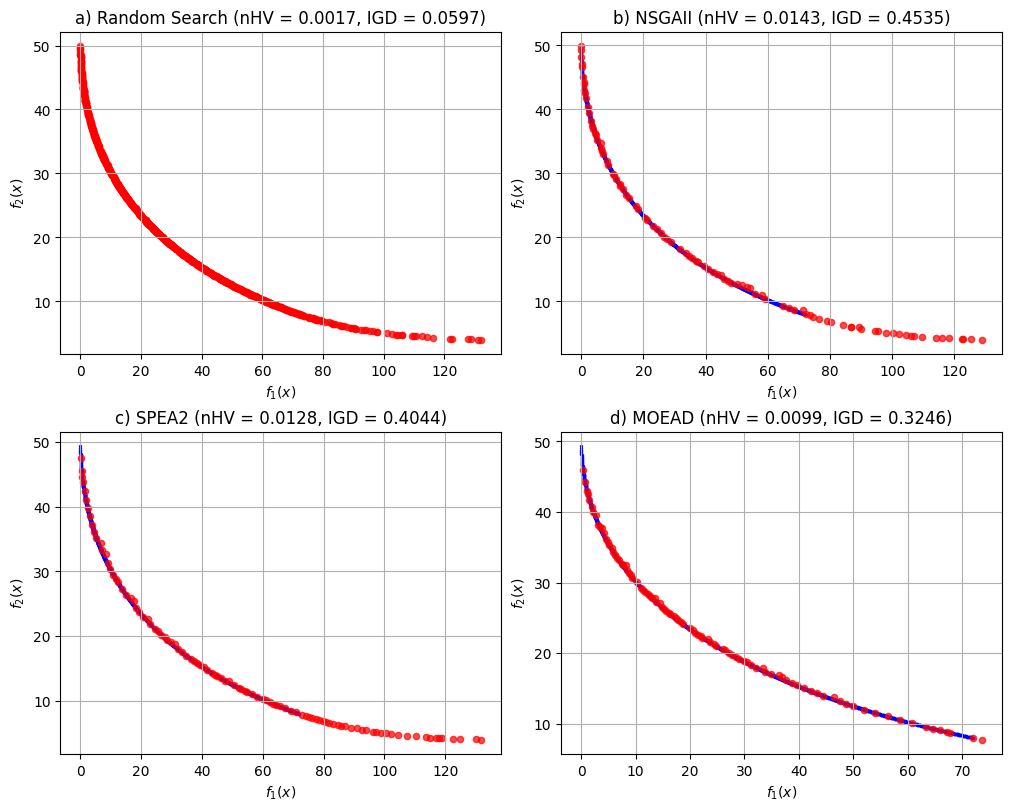

In [31]:
problem = Binh2()
generate_plots_2d(problem.name(), 9)

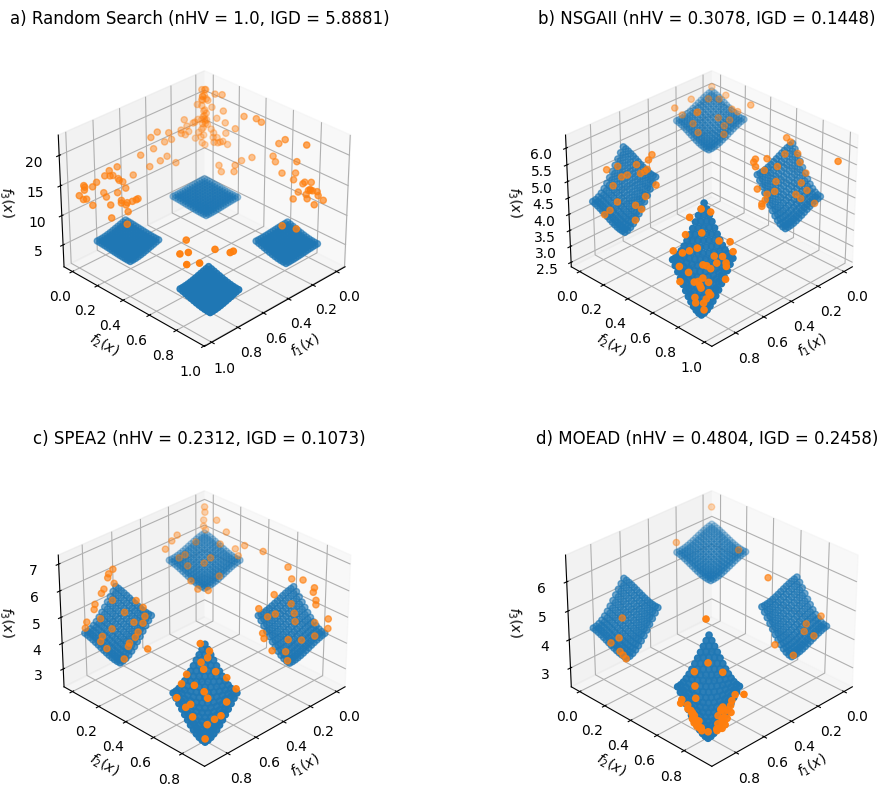

In [60]:
problem = DTLZ7()
generate_plots_3d(problem.name(), 2)

In [71]:
import os

def find_files_with_phrase(folder, phrase):
    result = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        if os.path.isfile(path) and phrase in filename:
            result.append(path)
    return result

In [103]:
def summarize_evaluation(problem_name, algorithm_name, indicator):
    folder = "results/comparative_analysis/"
    phrase = f"FUN.{algorithm_name}.{problem_name}"
    result_files = find_files_with_phrase(folder, phrase)

    ref_front = np.loadtxt(f"resources/reference_fronts/{problem_name}.pf")
    ref_front_dim = ref_front.shape[1]

    indicator_results = np.array([])
    for rf in result_files:
        fun = np.loadtxt(rf).reshape(-1, ref_front_dim)
        indicator_results = np.append(indicator_results, indicator.compute(fun))

    return np.mean(indicator_results), np.std(indicator_results)


problem_name = "Kursawe"
algorithm_name = "NSGAII"

ref_front = np.loadtxt(f"resources/reference_fronts/{problem_name}.pf")
hv_ref_point = np.max(ref_front, axis=0) + 0.1
hv = HyperVolume(hv_ref_point)
nhv = NormalizedHyperVolume(hv_ref_point, ref_front)
igd = InvertedGenerationalDistance(ref_front)

summarize_evaluation(problem_name, algorithm_name, igd)

(0.043008228479902696, 0.0014180471409929037)

In [104]:
summarize_evaluation(problem_name, algorithm_name, hv)

(27.446291690465262, 0.03025296040496479)

In [105]:
summarize_evaluation(problem_name, algorithm_name, nhv)

(0.013104544683711616, 0.0010878157774551153)

In [ ]:
def generate_summary_table(problem_name, iteration):
    ref_front = np.loadtxt(f"resources/reference_fronts/{problem_name}.pf")
    ref_x = ref_front[:, 0]
    ref_y = ref_front[:, 1]
    ref_z = ref_front[:, 2]

    hv_ref_point = np.max(ref_front, axis=0) + 0.1
    hv = HyperVolume(hv_ref_point)
    nhv = NormalizedHyperVolume(hv_ref_point, ref_front)
    igd = InvertedGenerationalDistance(ref_front)

    fun1 = np.loadtxt(f"results/comparative_analysis/FUN.Random Search.{problem_name}.{iteration}").reshape(-1, 3)
    fun1_x = fun1[:, 0]
    fun1_y = fun1[:, 1]
    fun1_z = fun1[:, 2]
    fun1_hv = hv.compute(fun1)
    fun1_nhv = nhv.compute(fun1)
    fun1_igd = igd.compute(fun1)

    fun2 = np.loadtxt(f"results/comparative_analysis/FUN.NSGAII.{problem_name}.{iteration}").reshape(-1, 3)
    fun2_x = fun2[:, 0]
    fun2_y = fun2[:, 1]
    fun2_z = fun2[:, 2]
    fun2_hv = hv.compute(fun2)
    fun2_nhv = nhv.compute(fun2)
    fun2_igd = igd.compute(fun2)

    fun3 = np.loadtxt(f"results/comparative_analysis/FUN.SPEA2.{problem_name}.{iteration}").reshape(-1, 3)
    fun3_x = fun3[:, 0]
    fun3_y = fun3[:, 1]
    fun3_z = fun3[:, 2]
    fun3_hv = hv.compute(fun3)
    fun3_nhv = nhv.compute(fun3)
    fun3_igd = igd.compute(fun3)

    fun4 = np.loadtxt(f"results/comparative_analysis/FUN.MOEAD.{problem_name}.{iteration}").reshape(-1, 3)
    fun4_x = fun4[:, 0]
    fun4_y = fun4[:, 1]
    fun4_z = fun4[:, 2]
    fun4_hv = hv.compute(fun4)
    fun4_nhv = nhv.compute(fun4)
    fun4_igd = igd.compute(fun4)

    fig = plt.figure(figsize=(12, 10))
    elev = 30
    azim = 45
    roll = 0
    ndigits = 4
    fontsize = 12
    zoom = 0.9
    ax = fig.add_subplot(221, projection='3d')
    ax.scatter3D(ref_x, ref_y, ref_z)
    ax.scatter3D(fun1_x, fun1_y, fun1_z)
    ax.set_box_aspect(None, zoom=zoom)
    ax.set_xlabel('$f_1{(x)}$')
    ax.set_ylabel('$f_2{(x)}$')
    ax.set_zlabel('$f_3{(x)}$')
    ax.view_init(elev, azim, roll)
    ax.set_title(f'a) Random Search (nHV = {round(fun1_nhv, ndigits)}, IGD = {round(fun1_igd, ndigits)})', fontsize=fontsize)

    ax = fig.add_subplot(222, projection='3d')
    ax.scatter3D(ref_x, ref_y, ref_z)
    ax.scatter3D(fun2_x, fun2_y, fun2_z)
    ax.set_box_aspect(None, zoom=zoom)
    ax.set_xlabel('$f_1{(x)}$')
    ax.set_ylabel('$f_2{(x)}$')
    ax.set_zlabel('$f_3{(x)}$')
    ax.view_init(elev, azim, roll)
    ax.set_title(f'b) NSGAII (nHV = {round(fun2_nhv, ndigits)}, IGD = {round(fun2_igd, ndigits)})', fontsize=fontsize)

    ax = fig.add_subplot(223, projection='3d')
    ax.scatter3D(ref_x, ref_y, ref_z)
    ax.scatter3D(fun3_x, fun3_y, fun3_z)
    ax.set_box_aspect(None, zoom=zoom)
    ax.set_xlabel('$f_1{(x)}$')
    ax.set_ylabel('$f_2{(x)}$')
    ax.set_zlabel('$f_3{(x)}$')
    ax.view_init(elev, azim, roll)
    ax.set_title(f'c) SPEA2 (nHV = {round(fun3_nhv, ndigits)}, IGD = {round(fun3_igd, ndigits)})', fontsize=fontsize)

    ax = fig.add_subplot(224, projection='3d')
    ax.scatter3D(ref_x, ref_y, ref_z)
    ax.scatter3D(fun4_x, fun4_y, fun4_z)
    ax.set_box_aspect(None, zoom=zoom)
    ax.set_xlabel('$f_1{(x)}$')
    ax.set_ylabel('$f_2{(x)}$')
    ax.set_zlabel('$f_3{(x)}$')
    ax.view_init(elev, azim, roll)
    ax.set_title(f'd) MOEAD (nHV = {round(fun4_nhv, ndigits)}, IGD = {round(fun4_igd, ndigits)})', fontsize=fontsize)

    plt.show()